In [1]:
import xarray
import numpy as np
import pandas
import h5py
import datetime
from ulmo.utils import image_utils
from ulmo.plotting import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cartopy.feature as cfeature
import os
import matplotlib.ticker as mticker
import healpy as hp

import cartopy
from ulmo.analysis.spatial_plots import evals_to_healpix, evals_to_healpix_stat, show_med_LL

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# this is going to be my Healpy images

In [2]:
aug10 = xarray.open_dataset('/home/jovyan/20120810120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc')
analysis_table = pandas.read_parquet('/home/jovyan/SST_L3S_VIIRS_2012.parquet')

In [5]:
eval_tbl = analysis_table
nside = 64
hpma, hp_lons, hp_lats, hp_values = evals_to_healpix_stat(eval_tbl, nside, metric = 'mean_temperature', stat = 'mean')

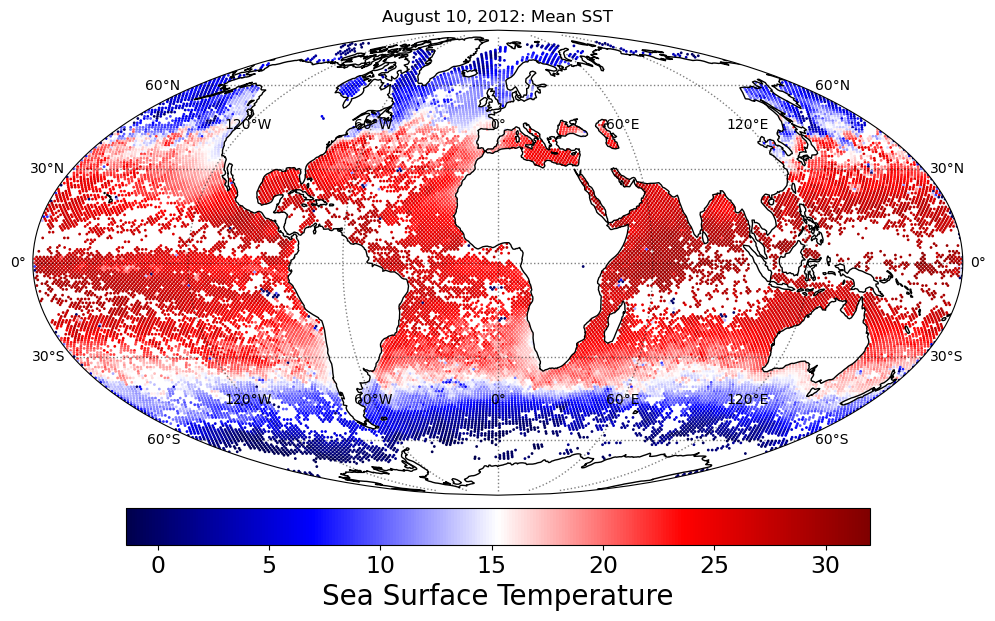

In [11]:
fig = plt.figure(figsize=(12,8))
color='seismic'
plt.clf()

tformM = ccrs.Mollweide()
tformP = ccrs.PlateCarree()

ax = plt.axes(projection=tformM)

cm = plt.get_cmap(color)
good = np.invert(hp_values.mask)
img = plt.scatter(x=hp_lons[good],
    y=hp_lats[good],
    c=hp_values[good],  
    cmap=cm,
    s=1,
    transform=tformP)

cb = plt.colorbar(img, orientation='horizontal', pad=0.02, shrink = 0.8)
clbl = 'Sea Surface Temperature'
cb.set_label(clbl, fontsize=20.)
cb.ax.tick_params(labelsize=17)
ax.coastlines(zorder=10)
ax.set_global()
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1,
                  color='black', alpha=0.5, linestyle=':', draw_labels=True)

gl.top_labels = True
gl.left_labels = True
gl.right_labels = True
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'color': 'black'}
plt.title("August 10, 2012: Mean SST")

plt.show()

#save_dir = os.path.expanduser('~/plots')
#save_filename = os.path.join(save_dir, 'plot1.png')

#plt.savefig(save_filename, dpi=300, bbox_inches='tight')
#plt.close(fig)

In [33]:
eval_tbl = table_2012
hpma, hp_lons, hp_lats, hp_values = evals_to_healpix_stat(eval_tbl, nside, metric = 'mean_temperature', stat = 'median')
# returns evts, hp_lons, hp_lats, meds
# I think I want to plot evts

/tmp/ipykernel_159/711595868.py:3: RuntimeWarning: divide by zero encountered in log
  hpma_log = np.log(hpma_mask)


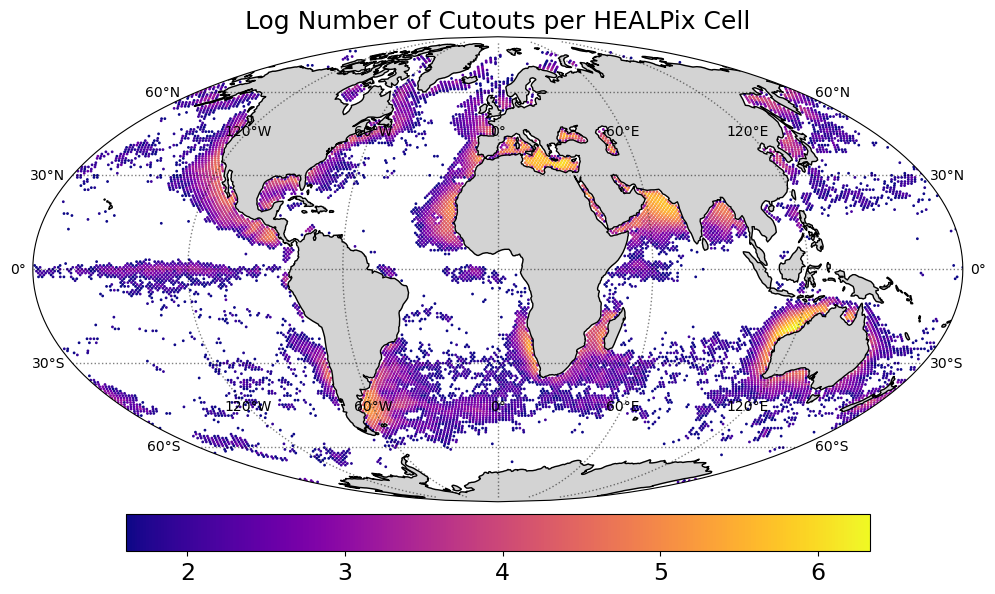

In [48]:
mask_less_than_5 = hpma < 5
hpma_mask = np.ma.masked_where(mask_less_than_5, hpma)
hpma_log = np.log(hpma_mask)

# Plot the Healpy map with the default cartopy color scale
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mollweide())

cm = plt.get_cmap('plasma')
good = np.invert(hpma_log.mask)
img = plt.scatter(
    x=hp_lons[good],
    y=hp_lats[good],
    c=hpma_log[good],
    cmap=cm,
    s=1,
    transform=ccrs.PlateCarree()
)

# Create a new color bar associated with the log-transformed data
cb = plt.colorbar(img, orientation='horizontal', pad=0.02, shrink=0.8)
cb.ax.tick_params(labelsize=17)

# Add coastlines and other map features
ax.coastlines(zorder=10)
ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
ax.set_global()

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle=':', draw_labels=True)
gl.top_labels = True
gl.left_labels = True
gl.right_labels = True
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'color': 'black'}

plt.title("Log Number of Cutouts per HEALPix Cell", fontsize=18)
plt.show()
#save_dir = os.path.expanduser('~/plots')
#save_filename = os.path.join(save_dir, 'plotnumberofcutouts.png')

#plt.savefig(save_filename, dpi=300, bbox_inches='tight')
#plt.close(fig)

# THIS IS CURRENTLY JUST 2012, so THERE ARE A LOT MASKED W LESS THAN 5, e^6 seems like a lot near coasts though

In [5]:
table_2012 = pandas.read_parquet('/home/jovyan/parquet/SST_L3S_VIIRS_2012.parquet')
#table_2013 = pandas.read_parquet('/home/jovyan/parquet/SST_L3S_VIIRS_2013.parquet')
#table_2014 = pandas.read_parquet('/home/jovyan/parquet/SST_L3S_VIIRS_2014.parquet')
#table_2015 = pandas.read_parquet('/home/jovyan/parquet/SST_L3S_VIIRS_2015.parquet')
#table_2016 = pandas.read_parquet('/home/jovyan/parquet/SST_L3S_VIIRS_2016.parquet')
#table_2017 = pandas.read_parquet('/home/jovyan/parquet/SST_L3S_VIIRS_2017.parquet')
#table_2018 = pandas.read_parquet('/home/jovyan/parquet/SST_L3S_VIIRS_2018.parquet')
#table_2019 = pandas.read_parquet('/home/jovyan/parquet/SST_L3S_VIIRS_2019.parquet')
#table_2020 = pandas.read_parquet('/home/jovyan/parquet/SST_L3S_VIIRS_2020.parquet')

ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

In [ ]:
table_all = pd.concat([table_2012, table_2013, table_2014, table_2015,
                        table_2016, table_2017, table_2018, table_2019, table_2020])

In [ ]:
table_2020

In [11]:
table_2012 = pandas.read_parquet('/home/jovyan/parquet/SST_L3S_VIIRS_2012.parquet')

In [12]:
table_2012

,VIIRS_row,VIIRS_col,VIIRS_UID,VIIRS_LL,VIIRS_pp_file,VIIRS_pp_idx,VIIRS_T90,VIIRS_T10,VIIRS_DT,VIIRS_pp_type,...,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,clear_fraction,DT,LL
0,3024,2784,13281093372310754,481.689453,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,32205,26.920013,26.429993,0.490021,0,...,261680,0,26.377739,25.899994,26.799988,26.570007,26.220001,1.0,0.350006,549.650513
1,3120,2688,13281101161369470,360.780640,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,252131,26.670013,25.809998,0.860016,0,...,217701,0,26.008064,25.130005,26.540009,26.359985,25.459991,1.0,0.899994,420.930664
2,3216,2496,13281110096482976,496.087891,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,459126,26.359985,25.950012,0.409973,0,...,230476,0,25.657494,24.970001,26.130005,25.950012,25.440002,1.0,0.510010,472.754517
3,3216,2592,13281108764419858,454.589905,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,379958,26.309998,25.829987,0.480011,0,...,137760,0,25.641016,24.920013,26.250000,25.940002,25.450012,1.0,0.489990,476.816528
4,3216,2688,13281107257349902,326.442383,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,217941,26.359985,25.609985,0.750000,0,...,114842,0,25.584072,24.980011,26.540009,26.000000,25.279999,1.0,0.720001,442.878052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293937,2448,1632,1356131747421868619,-65.451538,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,13938,12.109985,10.149994,1.959991,0,...,-1,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN
293938,3600,1440,1356124570321457391,10.163818,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,263538,19.660004,18.519989,1.140015,0,...,-1,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN
293939,3696,1440,1356123947221439336,40.828369,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,368096,19.859985,18.720001,1.139984,0,...,-1,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN
293940,3792,1440,1356123323721421495,210.555359,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,845868,19.959991,18.799988,1.160004,0,...,-1,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN


In [13]:
pandas.read_parquet('/home/jovyan/SST_L3S_VIIRS_2012.parquet')

ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.